### Wazobia Real Estate Limited is a prominent real estate company operating in Nigeria. With a vast portfolio of properties, they strive to provide accurate and competitive pricing for houses. However, they have been facing challenges in accurately predicting the prices of houses in the current market. 

#### The objective of this hackathon is to create a powerful and accurate predictive model that can estimate the prices of houses in Nigeria. 


##### Attribute Information:
- ID
- loc
- title
- bedroom
- bathroom
- parking_space
- price

In [256]:
# importing some libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split,KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings('ignore')

In [257]:
# Loading the datasets
train = pd.read_csv("Housing_dataset_train.csv")
test = pd.read_csv("Housing_dataset_test.csv")
sub = pd.read_csv("Sample_submission.csv")

####    Performing EDA

In [258]:
train

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898
...,...,...,...,...,...,...,...
13995,6175,Edo,Bungalow,NaN,7.0,NaN,2367927.861
13996,9704,Kaduna,Apartment,NaN,7.0,5.0,2228516.471
13997,11190,Plateau,Bungalow,8.0,6.0,5.0,2406812.693
13998,9256,Delta,Flat,NaN,6.0,1.0,3348918.718


In [259]:
train[train['price'] > 0].reset_index(drop = True)

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898
...,...,...,...,...,...,...,...
13995,6175,Edo,Bungalow,NaN,7.0,NaN,2367927.861
13996,9704,Kaduna,Apartment,NaN,7.0,5.0,2228516.471
13997,11190,Plateau,Bungalow,8.0,6.0,5.0,2406812.693
13998,9256,Delta,Flat,NaN,6.0,1.0,3348918.718


In [260]:
train.describe()

,ID,bedroom,bathroom,parking_space,price
count,14000.000000,12201.000000,12195.000000,12189.000000,1.400000e+04
mean,4862.700357,4.308171,3.134235,3.169825,2.138082e+06
std,3818.348214,2.441165,2.035950,1.599415,1.083057e+06
min,0.000000,1.000000,1.000000,1.000000,4.319673e+05
25%,1672.750000,2.000000,1.000000,2.000000,1.393990e+06
50%,3527.000000,4.000000,2.000000,3.000000,1.895223e+06
75%,8011.250000,6.000000,5.000000,4.000000,2.586699e+06
max,12999.000000,9.000000,7.000000,6.000000,1.656849e+07


In [261]:
test.head()

,ID,loc,title,bedroom,bathroom,parking_space
0,845,Kano,Penthouse,4,1,2
1,1924,Adamawa,Apartment,2,2,4
2,10718,Adamawa,Bungalow,2,7,2
3,12076,Lagos,Mansion,9,5,2
4,12254,Gombe,Semi-detached duplex,5,6,1


In [262]:
train.title.unique()

array(['Semi-detached duplex', 'Apartment', nan, 'Detached duplex',
       'Terrace duplex', 'Mansion', 'Bungalow', 'Penthouse', 'Townhouse',
       'Flat', 'Cottage'], dtype=object)

In [263]:
data = train.drop(["price"], axis=1)._append(test)
data.isnull().sum()

ID                  0
loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
dtype: int64

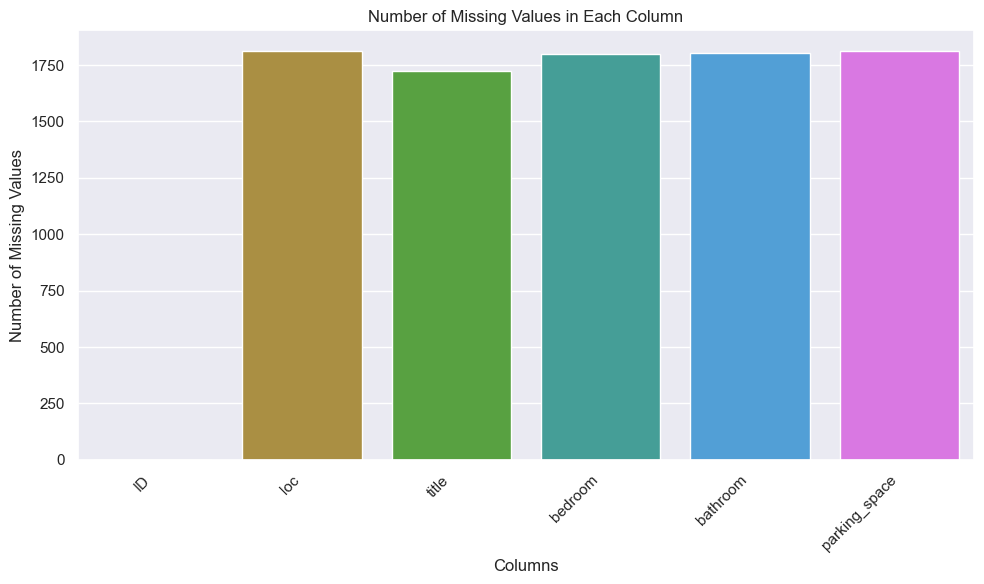

In [264]:
# Calculate the number of missing values in each column
missing_values_count = data.isnull().sum()

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values_count.index, y=missing_values_count.values, palette='husl')

# Set plot properties
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Number of Missing Values in Each Column')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


##### Ranking "title" based on size for train dataset

In [265]:
# Define the ranking based on size (arranged from smallest to biggest)
house_type_ranks = {
'Cottage': 1,
    'Bungalow': 2,
    'Townhouse': 3,
    'Terrace duplex': 4,
    'Detached duplex': 5,
    'Semi-detached duplex': 6,
    'Flat': 7,
    'Penthouse': 8,
    'Apartment': 9,
    'Mansion': 10,
}



# Map the house types to numerical values based on size ranking
data['title'] = data['title'].map(house_type_ranks)

# Print the updated dataframe
data.head()


,ID,loc,title,bedroom,bathroom,parking_space
0,3583,Katsina,6.0,2.0,2.0,1.0
1,2748,Ondo,9.0,NaN,2.0,4.0
2,9261,Ekiti,NaN,7.0,5.0,NaN
3,2224,Anambra,5.0,5.0,2.0,4.0
4,10300,Kogi,4.0,NaN,5.0,6.0


In [266]:
# Create the 'Total Rooms' feature
data['Total_Rooms'] = data['bedroom'] + data['bathroom']


# Create a new feature 'bathroom_bedroom_ratio'
data['Bathroom_to_Bedroom_Ratio'] = data['bathroom'] / data['bedroom']


# Print the updated dataframe with new features
data.head()

,ID,loc,title,bedroom,bathroom,parking_space,Total_Rooms,Bathroom_to_Bedroom_Ratio
0,3583,Katsina,6.0,2.0,2.0,1.0,4.0,1.000000
1,2748,Ondo,9.0,NaN,2.0,4.0,NaN,NaN
2,9261,Ekiti,NaN,7.0,5.0,NaN,12.0,0.714286
3,2224,Anambra,5.0,5.0,2.0,4.0,7.0,0.400000
4,10300,Kogi,4.0,NaN,5.0,6.0,NaN,NaN


In [267]:
data

,ID,loc,title,bedroom,bathroom,parking_space,Total_Rooms,Bathroom_to_Bedroom_Ratio
0,3583,Katsina,6.0,2.0,2.0,1.0,4.0,1.000000
1,2748,Ondo,9.0,NaN,2.0,4.0,NaN,NaN
2,9261,Ekiti,NaN,7.0,5.0,NaN,12.0,0.714286
3,2224,Anambra,5.0,5.0,2.0,4.0,7.0,0.400000
4,10300,Kogi,4.0,NaN,5.0,6.0,NaN,NaN
...,...,...,...,...,...,...,...,...
5995,1594,Ekiti,7.0,4.0,5.0,2.0,9.0,1.250000
5996,2416,Adamawa,4.0,5.0,7.0,1.0,12.0,1.400000
5997,10195,Oyo,3.0,4.0,1.0,4.0,5.0,0.250000
5998,9455,Bauchi,7.0,3.0,7.0,5.0,10.0,2.333333


In [268]:
# Dictionary to map states to geopolitical zones
state_to_zone = {
    "Abia": "South-East",
    'Adamawa': 'North-East',
    'Akwa Ibom': 'South-South',
    'Anambra': 'South-East',
    'Bauchi': 'North-East',
    'Bayelsa': 'South-South',
    'Benue': 'North-Central',
    'Borno': 'North-East',
    'Cross River': 'South-South',
    'Delta': 'South-South',
    'Ebonyi': 'South-East',
    'Edo': 'South-South',
    'Ekiti': 'South-West',
    'Enugu': 'South-East',
    'Gombe': 'North-East',
    'Imo': 'South-East',
    'Jigawa': 'North-West',
    'Kaduna': 'North-West',
    'Kano': 'North-West',
    'Katsina': 'North-West',
    'Kebbi': 'North-West',
    'Kogi': 'North-Central',
    'Kwara': 'North-Central',
    'Lagos': 'South-West',
    'Nasarawa': 'North-Central',
    'Niger': 'North-Central',
    'Ogun': 'South-West',
    'Ondo': 'South-West',
    'Osun': 'South-West',
    'Oyo': 'South-West',
    'Plateau': 'North-Central',
    'Rivers': 'South-South',
    'Sokoto': 'North-West',
    'Taraba': 'North-East',
    'Yobe': 'North-East',
    'Zamfara': 'North-West'
}

# Map the states to their respective regions
data['Region'] = data['loc'].map(state_to_zone)

# One-hot encode the 'Region' column
data = pd.get_dummies(data, columns=['Region'], prefix='', prefix_sep='')


# Print the updated dataframe with the 'Region' column
data.head()


,ID,loc,title,bedroom,bathroom,parking_space,Total_Rooms,Bathroom_to_Bedroom_Ratio,North-Central,North-East,North-West,South-East,South-South,South-West
0,3583,Katsina,6.0,2.0,2.0,1.0,4.0,1.000000,False,False,True,False,False,False
1,2748,Ondo,9.0,NaN,2.0,4.0,NaN,NaN,False,False,False,False,False,True
2,9261,Ekiti,NaN,7.0,5.0,NaN,12.0,0.714286,False,False,False,False,False,True
3,2224,Anambra,5.0,5.0,2.0,4.0,7.0,0.400000,False,False,False,True,False,False
4,10300,Kogi,4.0,NaN,5.0,6.0,NaN,NaN,True,False,False,False,False,False


In [269]:
# Extract the numerical features 'latitude' and 'loc' for imputation
impute_data = data.copy()

# Calculate the frequency of each category in the 'loc' column
category_frequencies = data['loc'].value_counts(normalize=True)

# Create a dictionary to map each category to its corresponding frequency
loc_frequency_mapping = category_frequencies.to_dict()

# Map the 'loc' column to its corresponding frequency values
data['loc'] = data['loc'].map(loc_frequency_mapping)

# Print the updated dataframe
data.head()


,ID,loc,title,bedroom,bathroom,parking_space,Total_Rooms,Bathroom_to_Bedroom_Ratio,North-Central,North-East,North-West,South-East,South-South,South-West
0,3583,0.028592,6.0,2.0,2.0,1.0,4.0,1.000000,False,False,True,False,False,False
1,2748,0.028097,9.0,NaN,2.0,4.0,NaN,NaN,False,False,False,False,False,True
2,9261,0.027822,NaN,7.0,5.0,NaN,12.0,0.714286,False,False,False,False,False,True
3,2224,0.029856,5.0,5.0,2.0,4.0,7.0,0.400000,False,False,False,True,False,False
4,10300,0.027382,4.0,NaN,5.0,6.0,NaN,NaN,True,False,False,False,False,False


In [270]:
data = data.drop("ID", axis=1)
data.head(2)

,loc,title,bedroom,bathroom,parking_space,Total_Rooms,Bathroom_to_Bedroom_Ratio,North-Central,North-East,North-West,South-East,South-South,South-West
0,0.028592,6.0,2.0,2.0,1.0,4.0,1.0,False,False,True,False,False,False
1,0.028097,9.0,NaN,2.0,4.0,NaN,NaN,False,False,False,False,False,True


In [271]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

# Assuming you have your dataframe 'data' and want to perform regression imputation on columns with missing values

# Create a copy of the dataframe to avoid modifying the original data
impute_data = data.copy()

# Get the columns with missing values
columns_with_missing = impute_data.columns[impute_data.isnull().any()]

# Perform regression imputation for each column with missing values
for target in columns_with_missing:
    # Select features for regression imputation (consider using other relevant features if available)
    features = impute_data.columns.difference([target])
    
    # Split the data into known (non-missing) and missing values for the target feature
    known_data = impute_data.loc[impute_data[target].notnull(), features.to_list() + [target]]
    missing_data = impute_data.loc[impute_data[target].isnull(), features.to_list()]

    # Separate the target and features for known and missing data
    X_known = known_data[features]
    y_known = known_data[target]
    X_missing = missing_data[features]

    # Create a regression model
    regression_model = LGBMRegressor()

    # Fit the regression model on the known data
    regression_model.fit(X_known, y_known)

    # Predict the missing values using the regression model
    imputed_values = regression_model.predict(X_missing)

    # Fill the missing values in the original dataframe
    impute_data.loc[impute_data[target].isnull(), target] = imputed_values

# Print the updated dataframe with filled missing values
impute_data


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 115
[LightGBM] [Info] Number of data points in the train set: 18187, number of used features: 12
[LightGBM] [Info] Start training from score 0.027820
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 358
[LightGBM] [Info] Number of data points in the train set: 18278, number of used features: 12
[LightGBM] [Info] Start training from score 5.839698
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is no

,loc,title,bedroom,bathroom,parking_space,Total_Rooms,Bathroom_to_Bedroom_Ratio,North-Central,North-East,North-West,South-East,South-South,South-West
0,0.028592,6.000000,2.000000,2.0,1.000000,4.000000,1.000000,False,False,True,False,False,False
1,0.028097,9.000000,4.168396,2.0,4.000000,5.174911,0.520471,False,False,False,False,False,True
2,0.027822,6.081904,7.000000,5.0,3.831819,12.000000,0.714286,False,False,False,False,False,True
3,0.029856,5.000000,5.000000,2.0,4.000000,7.000000,0.400000,False,False,False,True,False,False
4,0.027382,4.000000,5.068511,5.0,6.000000,9.899205,0.999991,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.027822,7.000000,4.000000,5.0,2.000000,9.000000,1.250000,False,False,False,False,False,True
5996,0.028372,4.000000,5.000000,7.0,1.000000,12.000000,1.400000,False,True,False,False,False,False
5997,0.028812,3.000000,4.000000,1.0,4.000000,5.000000,0.250000,False,False,False,False,False,True
5998,0.028427,7.000000,3.000000,7.0,5.000000,10.000000,2.333333,False,True,False,False,False,False


In [272]:
data = impute_data.copy()

In [273]:
data.isnull().sum()

loc                          0
title                        0
bedroom                      0
bathroom                     0
parking_space                0
Total_Rooms                  0
Bathroom_to_Bedroom_Ratio    0
North-Central                0
North-East                   0
North-West                   0
South-East                   0
South-South                  0
South-West                   0
dtype: int64

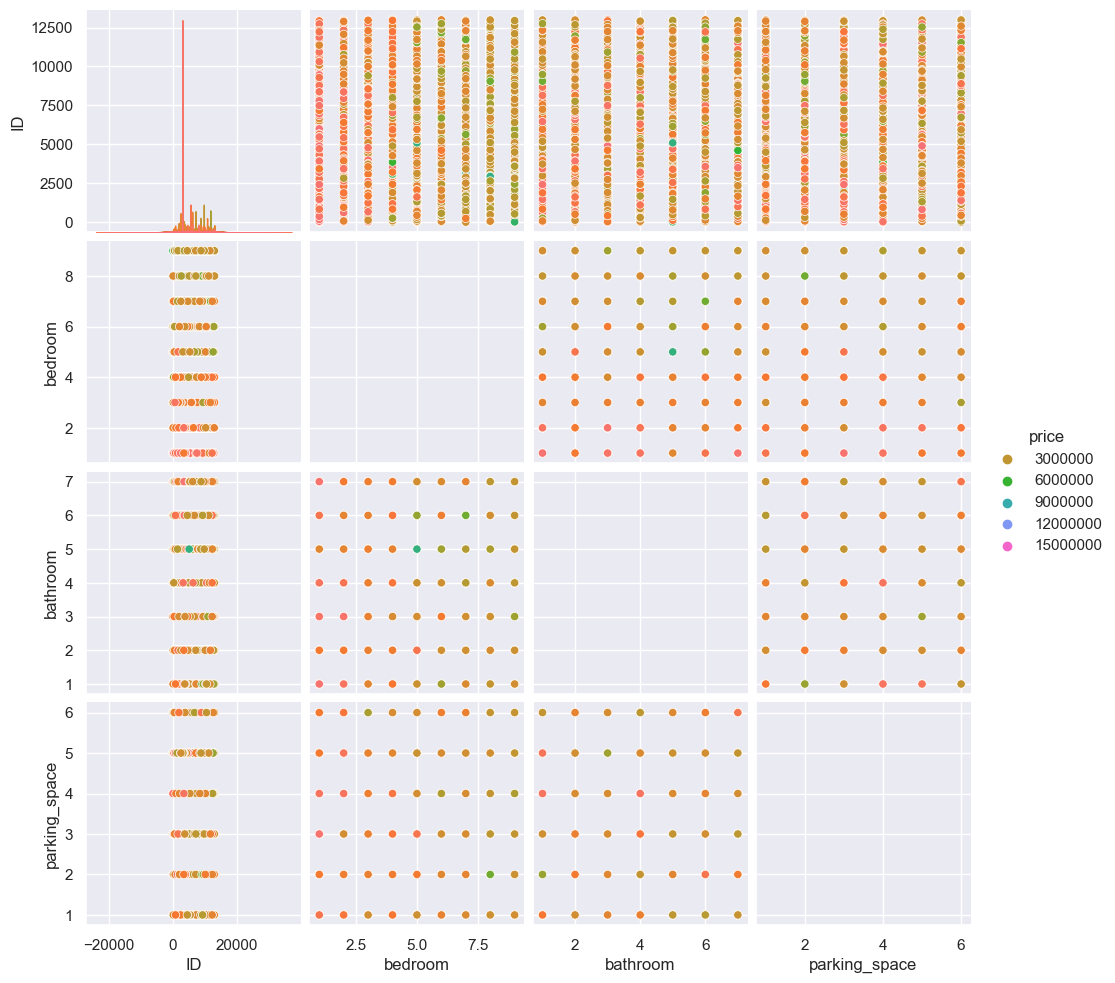

In [274]:
g = sns.pairplot(train, hue="price", palette="husl")

In [275]:
train.shape[0]

14000

In [276]:
X = data[:train.shape[0]]
y = train.price
test_df = data[train.shape[0]:]

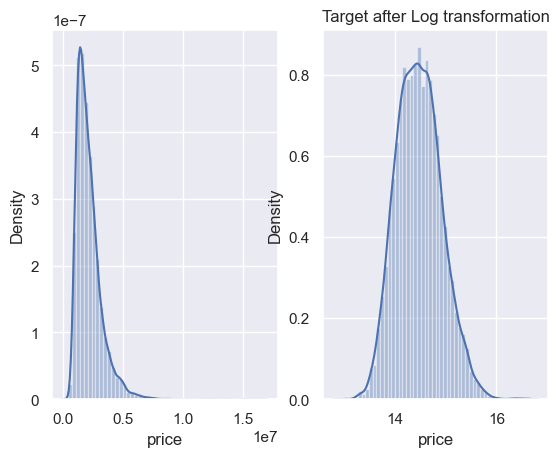

In [277]:
sns.set()
y_transformed = pd.Series(np.log1p(y))

fig, ax = plt.subplots(1, 2)
sns.distplot(y, ax=ax[0])
plt.title("Target after Log transformation")
# ax[0].axvline(y_transformed)
sns.distplot(y_transformed, ax=ax[1])
plt.show()

### Train and test split

In [278]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state= 150)

#### Model Building

In [279]:
# first using LGBMRegressor
lgb = LGBMRegressor()
lgb.fit(X_train, y_train)
lgb_preds = lgb.predict(X_test)

print(f'mse = {mean_squared_error(y_test, lgb_preds, squared=False)}')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1437
[LightGBM] [Info] Number of data points in the train set: 11200, number of used features: 13
[LightGBM] [Info] Start training from score 2140949.311214
mse = 623368.8191480667


In [280]:
predictions = lgb.predict(test_df)
predictions

array([2184117.28881046, 1012548.9426032 , 1240799.42770877, ...,
       2077383.10186708, 1428448.6467231 , 2748850.33128002])

In [281]:
sub['price'] = predictions
sub.head()

,ID,price
0,845,2.184117e+06
1,1924,1.012549e+06
2,10718,1.240799e+06
3,12076,8.092010e+06
4,12254,1.949913e+06


In [282]:
sub.to_csv(' LGBMRegressor model.csv', index=False)

In [283]:
# 2nd using CatboostRegressor
fold_pred=[]
oof_pred = []

params = {'learning_rate': 0.08067664526726463, 'max_depth': 5, 'n_estimators': 312}



fold= KFold(n_splits=15, shuffle=True, random_state=2023)#15#5#10
for train_index, test_index in fold.split(X,y):    
  
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = np.sqrt(y.iloc[train_index]), y.iloc[test_index]

    model = CatBoostRegressor(**params)
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100, verbose = False)#erly100

    preds= model.predict(X_test)
    print("err: ",(mean_squared_error(y_test,preds**2, squared=False)))  #Reverse transformation
    oof_pred.append(mean_squared_error(y_test,preds**2,squared=False))
    p2 = model.predict(test_df[X.columns])
    fold_pred.append(p2**2)
    

print(np.mean(oof_pred))

err:  533198.5042839958
err:  680037.5254689013
err:  541603.6305037615
err:  454550.6150516433
err:  592620.6917232517
err:  617962.7309115684
err:  463626.5127476954
err:  493661.7561253183
err:  636369.0852140437
err:  469801.57567794324
err:  626861.5065156594
err:  495073.9182451219
err:  511345.7055633228
err:  445845.724050992
err:  453662.94377708173
534414.8283906867


In [284]:
len(fold_pred)

15

Text(0.5, 1.0, 'CatboostRegressor features importance (top):')

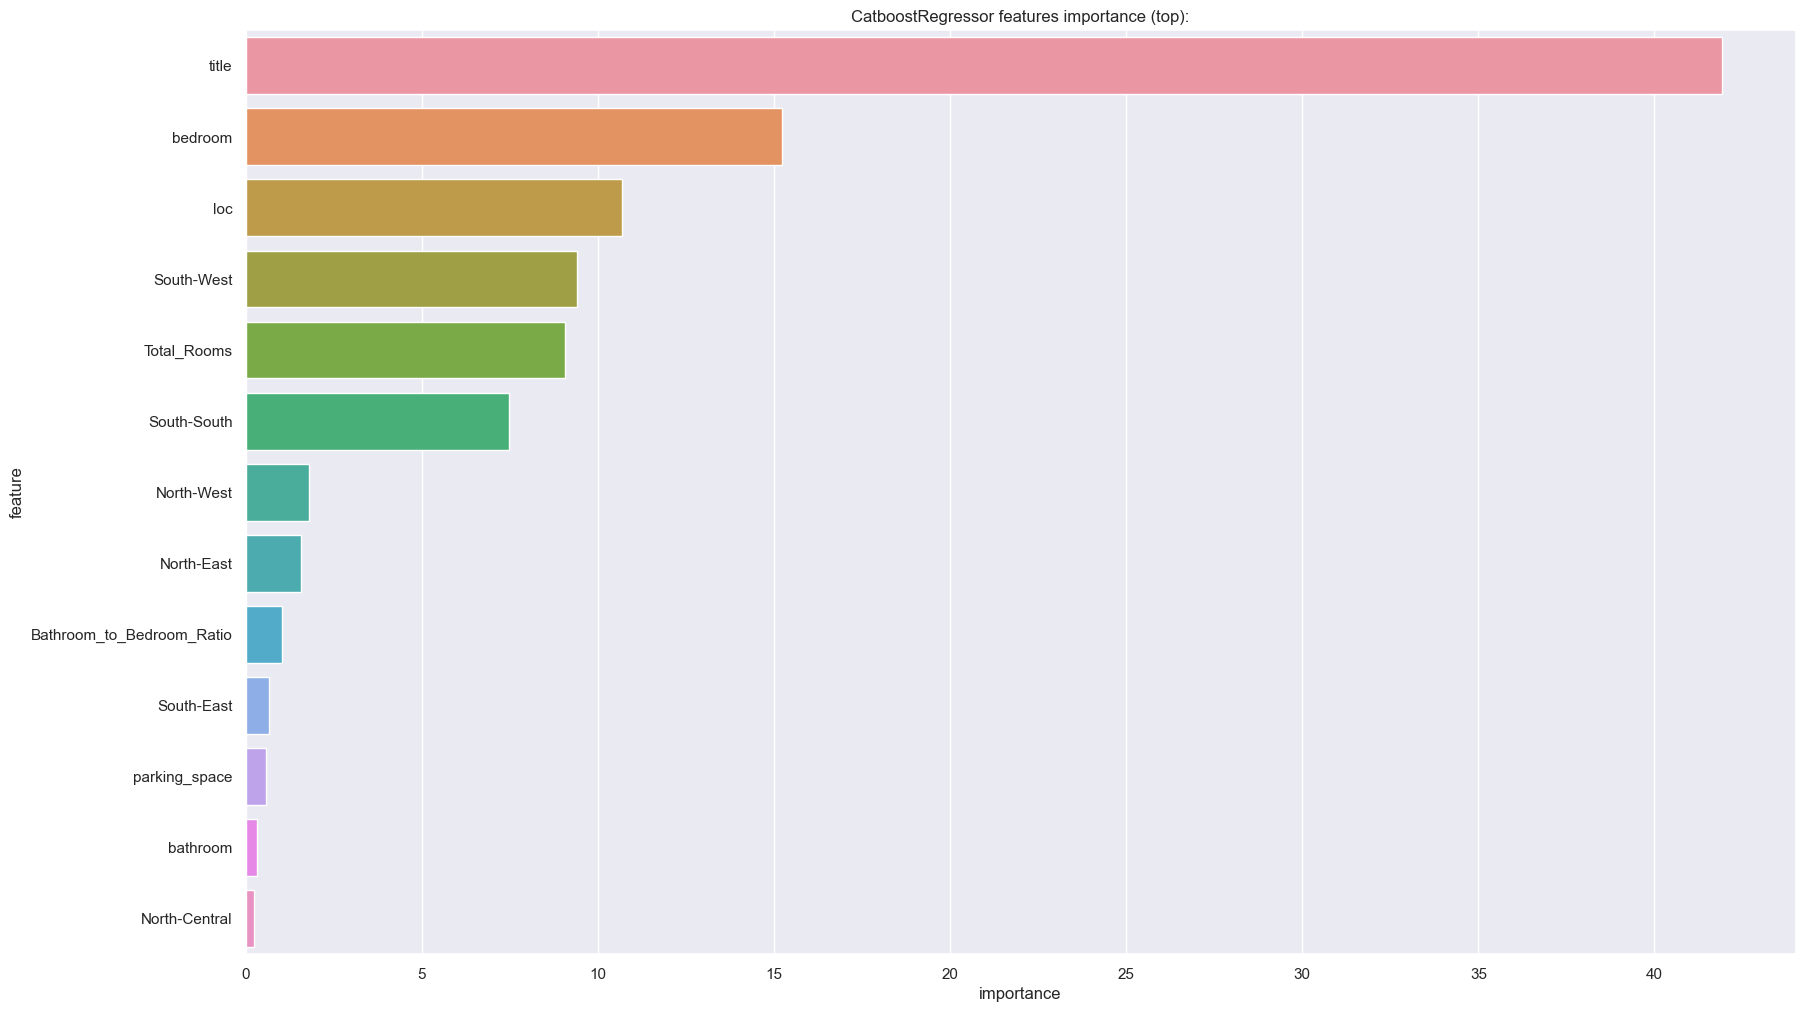

In [285]:
# feature importance
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('CatboostRegressor features importance (top):')

In [286]:
sub.head()

,ID,price
0,845,2.184117e+06
1,1924,1.012549e+06
2,10718,1.240799e+06
3,12076,8.092010e+06
4,12254,1.949913e+06


In [287]:
sub['price'] =  np.mean(fold_pred, axis = 0)

In [288]:
sub.head()

,ID,price
0,845,2.185591e+06
1,1924,9.847476e+05
2,10718,1.246746e+06
3,12076,8.602698e+06
4,12254,1.891029e+06


In [289]:
sub.to_csv('Catboost model.csv', index=False)